In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg
import heapq
import random
from functions import plot_all

%matplotlib inline

In [2]:
def grad_U(Ui, Yij, Vj, a, b, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj) - a - b))

In [3]:
def grad_V(Vj, Yij, Ui, a, b, reg, eta):    
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj) - a - b))

In [4]:
def grad_a(Vj, Yij, Ui, a, b, reg, eta): 
    return eta * (reg * a - (Yij - np.dot(Ui, Vj) - a - b))

def grad_b(Vj, Yij, Ui, a, b, reg, eta): 
    return eta * (reg * b - (Yij - np.dot(Ui, Vj) - a - b))

In [5]:
def get_err(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for y in Y:
        err += (y[2] - (np.dot(U[y[0] - 1], V[y[1] - 1]) + a[y[0] - 1] + b[y[1] - 1]))**2
    err /= 2.0
    err += (reg / 2) * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2)
    err /= len(Y)
    
    return err

In [6]:
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # epoch counter and initial matrices
    k = 0
    U = np.random.random_sample((M, K)) - 0.5
    V = np.random.random_sample((N, K)) - 0.5
    a = np.random.random_sample(M) - 0.5
    b = np.random.random_sample(N) - 0.5
    err = 0
    erri = 0
    
    # Start the epoch runs
    while(k < max_epochs):
        
        # random permutation of the indices
        inds = np.arange(len(Y))
        np.random.shuffle(inds)
        
        # run on epoch
        for y in inds:
            i,j,v = Y[y][0] - 1, Y[y][1] - 1, Y[y][2]
            temp_u, temp_v, temp_a, temp_b = np.copy(U[i]), np.copy(V[j]), a[i], b[j]
            U[i] -= grad_U(temp_u, v, temp_v, temp_a, temp_b, reg, eta)
            V[j] -= grad_V(temp_v, v, temp_u, temp_a, temp_b, reg, eta)
            a[i] -= grad_a(temp_v, v, temp_u, temp_a, temp_b, reg, eta)
            b[j] -= grad_b(temp_v, v, temp_u, temp_a, temp_b, reg, eta)
        
        # Compute new error
        new_error = get_err(U, V, Y, a, b)
        # Break if error less than eps.
        if (k==0):
            err = new_error
            erri = new_error
        elif((err - new_error) / erri < eps):
            break
        else:
            err = new_error
            
        # increment counter
        k += 1
    
    # return MSE and UV
    return (U, V, a, b, err)

In [7]:
# Load Data
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

('Factorizing with ', 943, ' users, ', 1682, ' movies.')


In [8]:
reg = 0.1
eta = 0.03 # learning rate
K = 20

U,V, a, b, E_in = train_model(M, N, K, eta, reg, Y_train)
E_out = get_err(U, V, Y_test, a, b)

Do SVD

In [9]:
users_2d, _, _ = np.linalg.svd(U, full_matrices=True)
movies_2d, _, _ = np.linalg.svd(V, full_matrices=True)

Plot users and movies

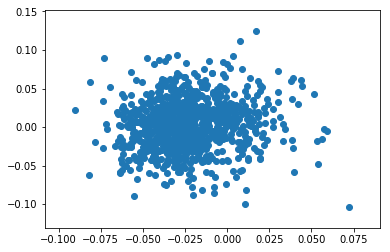

In [10]:
plt.scatter(users_2d[0],
            users_2d[1])

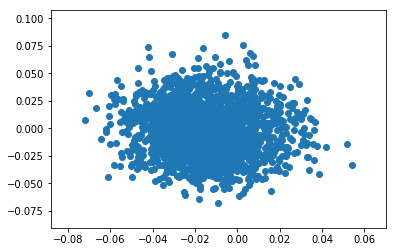

In [11]:
plt.scatter(movies_2d[0],
            movies_2d[1])

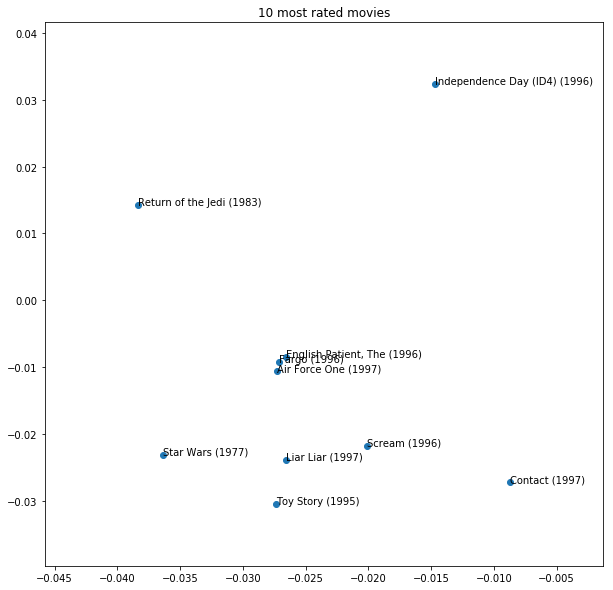

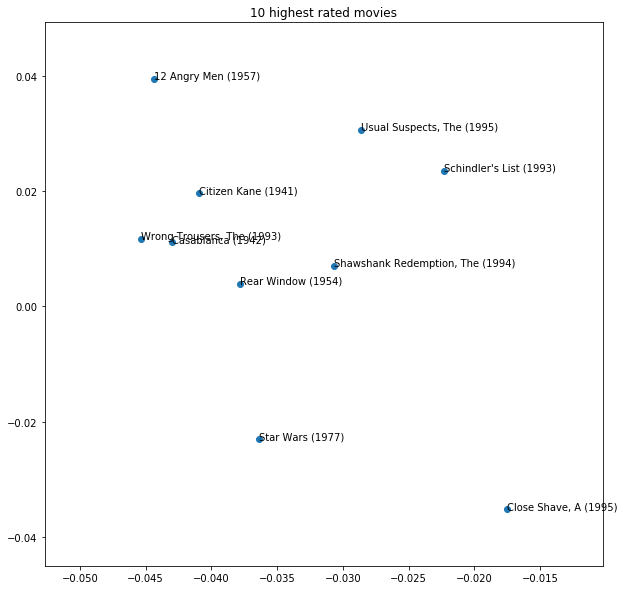

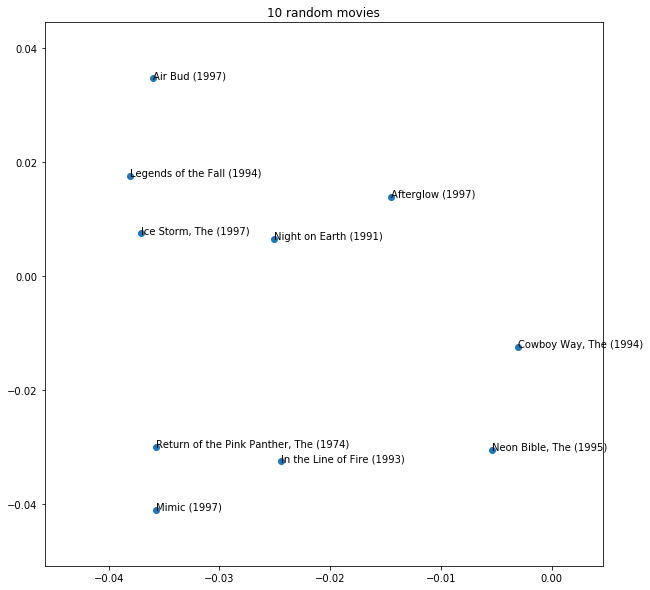

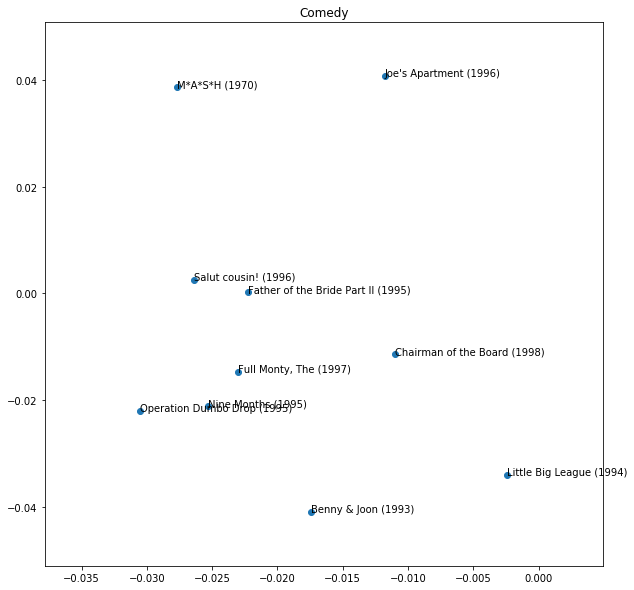

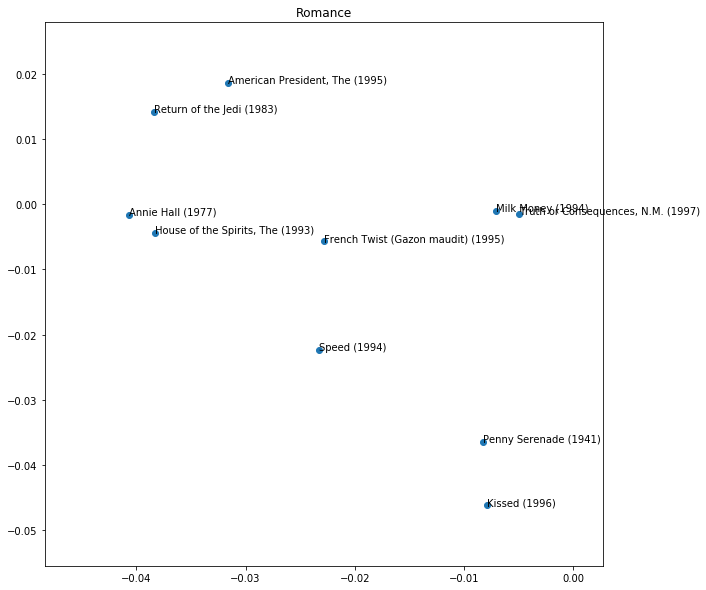

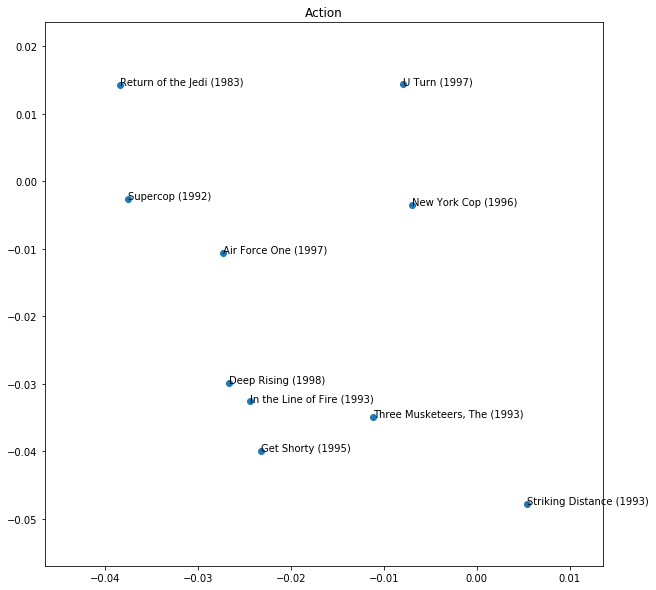

In [12]:
plot_all(V, "HW5+Biase")

In [13]:
E_in

0.27659479664580605

In [14]:
E_out

0.42863160631292546

We'll make an interesting visualization where we look at the 100 most active users (the one's that rated the most movies) to see if the biggest critics have similar taste.

In [15]:
Y_data = np.loadtxt('data/data.txt').astype(int)
ratings = Y_data[:, 2]
movies = Y_data[:, 1]
users = Y_data[:, 0]

In [16]:
user_counts = np.bincount(users)
top_100_counts = heapq.nlargest(100, user_counts)
top_100_users = []

for i in range(len(top_100_counts)):
    users_id = np.where(user_counts == top_100_counts[i])[0][0]
    top_100_users.append(users_id)

top_100_users = np.asarray(top_100_users)
print top_100_users

s_100_counts = heapq.nsmallest(101, user_counts)[1:]
s_100_users = []

for i in range(len(s_100_counts)):
    curr_count = s_100_counts[i]
    if (i > 0): 
        if (curr_count != prev_count):
            users_id = np.where(user_counts == s_100_counts[i])[0].tolist()
            s_100_users += users_id
        prev_count = curr_count
    else:
        users_id = np.where(user_counts == s_100_counts[i])[0].tolist()
        s_100_users += users_id
        prev_count = curr_count

s_100_users = np.asarray(s_100_users)
print s_100_users

[405 655  13 450 276 416 537 303 234 393 181 279 429 846   7  94 682 308
  92  92 222 201  59 435 378 880 417 896 592 796 561 561 130 406 551 334
 804 268 474 889 269 727 399 642 916 145 363 363 151 524 194 194 387  90
 648 291 311 311 747  85  85 327 328 328 385 299 497  95  95  18  18 301
 374 374 178 178   1 389 716 716 883 833 437 437 313 533 881 280 339 184
 184 788 314 314 314 506 932 886 798 244]
[ 19  34  36  93 143 147 166 202 242 300 309 364 418 441 475 558 571 572
 596 631 636 685 732 740 809 812 824 866 873 888 895 926  55  61  78  88
 140 228 231 252 302 310 341 431 512 516 651 687 700 729 762 811 818 820
 858 876   9  39 107 132 155 170 205 220 245 273 282 317 335 369 384 400
 513 570 652 681 723 857 941  51  86 105 127 153 163 241 258 266 278 319
 386 461 520 547 662 765 808 849 855 914]


In [17]:
master_list = users_2d[:, [0,1]]
top_100_x, top_100_y = [], []
for i in top_100_users:
    top_100_x.append(master_list[i][0])
    top_100_y.append(master_list[i][1])

s_100_x, s_100_y = [], []
for i in s_100_users:
    s_100_x.append(master_list[i][0])
    s_100_y.append(master_list[i][1])

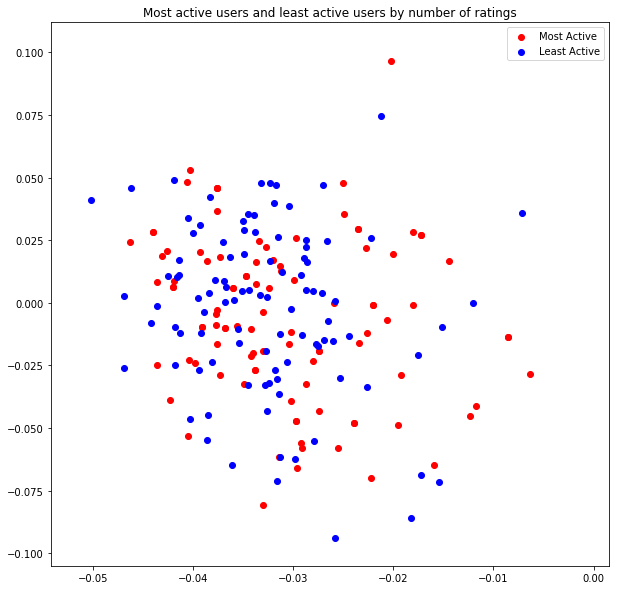

In [18]:
plt.figure(figsize=(10, 10))
plt.title("Most active users and least active users by number of ratings")
plt.scatter(top_100_x, top_100_y, color='red', label="Most Active")
plt.scatter(s_100_x, s_100_y, color='blue', label="Least Active")
plt.legend()